# NNDL - HW6 - Q1

# Import Packages

In [1]:
import os
from PIL import Image
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Dataset

In [4]:
anime_faces_path = '/kaggle/input/animefacedataset/images'
cartoon_faces_base_path = '/kaggle/input/cartoon-faces-googles-cartoon-set/cartoonset100k_jpg'
combined_dataset_path = '/kaggle/working/combined_dataset'

os.makedirs(combined_dataset_path, exist_ok=True)
def copy_images_with_label(src_dir, dest_dir, label):
    image_files = [img for img in os.listdir(src_dir) if img.endswith('.jpg') or img.endswith('.png')]
    for img_file in tqdm(image_files, desc=f"Copying {label} images"):
        src_file_path = os.path.join(src_dir, img_file)
        dest_file_path = os.path.join(dest_dir, f"{label}_{img_file}")
        shutil.copy(src_file_path, dest_file_path)

## Anime Faces

In [ ]:
copy_images_with_label(anime_faces_path, combined_dataset_path, 'anime')

## Cartoon Faces

In [ ]:
cartoon_folders = [str(i) for i in range(10)]

selected_cartoon_folders = random.sample(cartoon_folders, 5)
for folder in selected_cartoon_folders:
    folder_path = os.path.join(cartoon_faces_base_path, folder)
    copy_images_with_label(folder_path, combined_dataset_path, 'cartoon')

In [ ]:
file_count = sum([len(files) for _, _, files in os.walk(anime_faces_path)])
print(f"Total number of files in '{anime_faces_path}': {file_count}")

### **50000 from Cartoons + 63565 from Anime = 113565**

# Load Combined Folder

In [3]:
zip_path = '/kaggle/input/nndl-hw6-q1/_output_.zip'
extraction_path = '/kaggle/working/extracted_dataset'
os.makedirs(extraction_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [4]:
dataset_path = '/kaggle/working/extracted_dataset/combined_dataset/'
file_count = sum([len(files) for _, _, files in os.walk(dataset_path)])
print(f"Total number of files in Combined Folder: {file_count}")

Total number of files in Combined Folder: 113565


## Create Custom Dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataset_path, mode='combined', transform=None):
        self.dataset_path = dataset_path
        self.mode = mode
        self.transform = transform
        self.image_files = [f for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))]
        
        if mode == 'anime':
            self.image_files = [f for f in self.image_files if 'anime' in f]
        elif mode == 'cartoon':
            self.image_files = [f for f in self.image_files if 'cartoon' in f]
        elif mode == 'combined':
            anime_files = [f for f in self.image_files if 'anime' in f]
            cartoon_files = [f for f in self.image_files if 'cartoon' in f]
            selected_anime_files = random.sample(anime_files, 50000)
            selected_cartoon_files = cartoon_files[:50000]
            self.image_files = selected_anime_files + selected_cartoon_files
        
        self.labels = [self.get_label_from_filename(f) for f in self.image_files]

    def get_label_from_filename(self, filename):
        return filename.split('_')[0]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.dataset_path, self.image_files[idx])
        #image = Image.open(img_name).convert("RGB")
        image = Image.open(img_name).convert("L")  # Grayscale for CVAE
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
            
        label = 0 if label == 'anime' else 1
        return image, label

## Preprocessing

In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),      
    transforms.CenterCrop(128),        
    transforms.ToTensor(),            
   #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]
])

## Dataset and Dataloader

In [7]:
anime_dataset = CustomDataset(dataset_path, mode='anime', transform=transform)

cartoon_dataset = CustomDataset(dataset_path, mode='cartoon', transform=transform)

combined_dataset = CustomDataset(dataset_path, mode='combined', transform=transform)

print('Anime Dataset:', len(anime_dataset))
print('Cartoon Dataset:', len(cartoon_dataset))
print('Combined Dataset:', len(combined_dataset))

Anime Dataset: 63565
Cartoon Dataset: 50000
Combined Dataset: 100000


In [8]:
anime_dataloader = DataLoader(anime_dataset, batch_size=128, shuffle=True)
cartoon_dataloader = DataLoader(cartoon_dataset, batch_size=128, shuffle=True)
combined_dataloader = DataLoader(combined_dataset, batch_size=128, shuffle=True)

In [9]:
for images, labels in anime_dataloader:
    print(images.shape, labels.shape)
    break

torch.Size([128, 1, 128, 128]) torch.Size([128])


## Display 5 Images from Each Dataset

In [10]:
def plot_random_images_with_labels(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
    for ax in axes:
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)  
        ax.imshow(img)
        ax.set_title(f"{'Anime' if label == 0 else 'Cartoon'}")
        ax.axis('off')
    plt.show()

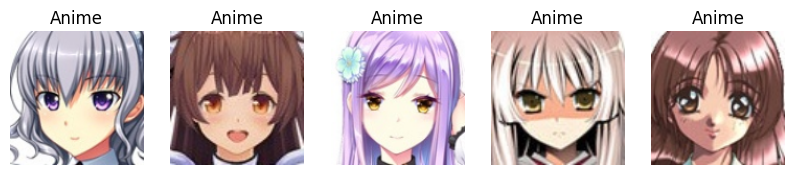

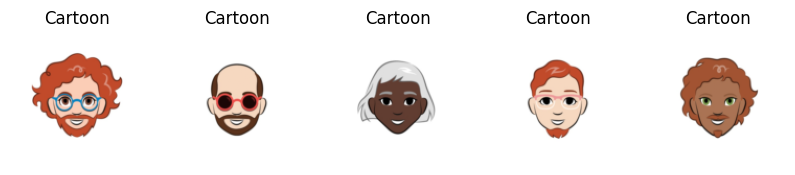

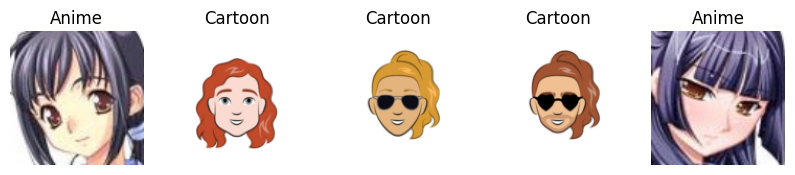

In [11]:
plot_random_images_with_labels(anime_dataset)
plot_random_images_with_labels(cartoon_dataset)
plot_random_images_with_labels(combined_dataset)

# Part 2 - VAE

## Convolutional VAE Model

In [12]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc_conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.enc_conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc_mu = nn.Linear(1024, 256)
        self.fc_logvar = nn.Linear(1024, 256)
        
        # Decoder
        self.fc2 = nn.Linear(256, 1024)
        self.fc3 = nn.Linear(1024, 512 * 4 * 4)
        self.dec_conv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.dec_conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_conv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_conv5 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)
        
    def encode(self, x):
        h = torch.relu(self.enc_conv1(x))
        h = torch.relu(self.enc_conv2(h))
        h = torch.relu(self.enc_conv3(h))
        h = torch.relu(self.enc_conv4(h))
        h = torch.relu(self.enc_conv5(h))
        h = h.view(-1, 512 * 4 * 4)
        h = torch.relu(self.fc1(h))
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.fc2(z))
        h = torch.relu(self.fc3(h))
        h = h.view(-1, 512, 4, 4)
        h = torch.relu(self.dec_conv1(h))
        h = torch.relu(self.dec_conv2(h))
        h = torch.relu(self.dec_conv3(h))
        h = torch.relu(self.dec_conv4(h))
        return torch.sigmoid(self.dec_conv5(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Train Loop

In [13]:
def train_vae(model, dataloader, num_epochs=5):
    model.train()
    train_loss_history = []
    recon_loss_history = []
    kld_loss_history = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        recon_loss = 0
        kld_loss = 0
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        for images, _ in progress_bar:
            images = images.to(device)
            optimizer.zero_grad()
            recon_images, mu, logvar = model(images)
            bce_loss, kld_loss = loss_function(recon_images, images, mu, logvar)
            loss = bce_loss + kld_loss
            loss.backward()
            train_loss += loss.item()
            recon_loss += bce_loss.item()
            kld_loss += kld_loss.item()
            optimizer.step()
            
            progress_bar.set_postfix(loss=loss.item())
        
        avg_train_loss = train_loss / len(dataloader.dataset)
        avg_recon_loss = recon_loss / len(dataloader.dataset)
        avg_kld_loss = kld_loss / len(dataloader.dataset)
        train_loss_history.append(avg_train_loss)
        recon_loss_history.append(avg_recon_loss)
        kld_loss_history.append(avg_kld_loss)
        print(f"Epoch {epoch + 1}, Total Loss: {avg_train_loss}, Recon Loss: {avg_recon_loss}, KLD Loss: {avg_kld_loss}")
    
    return train_loss_history, recon_loss_history, kld_loss_history

## Generate and Save Functions

In [22]:
def plot_training_loss(train_loss_history, recon_loss_history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Total Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Total Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recon_loss_history, label='Reconstruction Loss', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Reconstruction Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def generate_and_save_images_vae(model, num_images=8, latent_dim=256, save_path='/kaggle/working/vae_generated_images'):
    os.makedirs(save_path, exist_ok=True)
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)
        generated_images = model.decode(z)
        generated_images = generated_images.cpu()
        
        for i in range(num_images):
            save_image(generated_images[i], os.path.join(save_path, f'vae_generated_image_{i}.png'))
        
        fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
        for i, ax in enumerate(axes):
            ax.imshow(generated_images[i].permute(1, 2, 0))
            ax.axis('off')
        plt.show()
        
def generate_and_plot_images(model, num_images=8):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, 256).to(device)
        generated_images = model.decode(z)
        generated_images = generated_images.cpu()
        
        fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
        for i, ax in enumerate(axes):
            ax.imshow(generated_images[i].permute(1, 2, 0))
            ax.axis('off')
        plt.show()    

## Train Convolutional VAE on Anime Face

In [15]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [16]:
train_loss_history, recon_loss_history, kld_loss_history = train_vae(model, anime_dataloader, num_epochs=10)

Epoch 1/10: 100%|██████████| 497/497 [01:34<00:00,  5.23it/s, loss=2.14e+6]


Epoch 1, Total Loss: 28618.410823566428, Recon Loss: 28551.27292141902, KLD Loss: 0.25228187441825867


Epoch 2/10: 100%|██████████| 497/497 [01:29<00:00,  5.54it/s, loss=2.04e+6]


Epoch 2, Total Loss: 27053.92327932038, Recon Loss: 26935.022630378353, KLD Loss: 0.3117438852787018


Epoch 3/10: 100%|██████████| 497/497 [01:30<00:00,  5.51it/s, loss=2.02e+6]


Epoch 3, Total Loss: 26631.09715055455, Recon Loss: 26507.97058522772, KLD Loss: 0.30616453289985657


Epoch 4/10: 100%|██████████| 497/497 [01:28<00:00,  5.58it/s, loss=2.05e+6]


Epoch 4, Total Loss: 26400.780250530952, Recon Loss: 26275.360426335246, KLD Loss: 0.2879601716995239


Epoch 5/10: 100%|██████████| 497/497 [01:29<00:00,  5.54it/s, loss=2.02e+6]


Epoch 5, Total Loss: 26237.502560371275, Recon Loss: 26111.218431920082, KLD Loss: 0.31624579429626465


Epoch 6/10: 100%|██████████| 497/497 [01:29<00:00,  5.55it/s, loss=2.02e+6]


Epoch 6, Total Loss: 26116.012915912845, Recon Loss: 25989.495016911824, KLD Loss: 0.3163139224052429


Epoch 7/10: 100%|██████████| 497/497 [01:28<00:00,  5.58it/s, loss=2e+6]   


Epoch 7, Total Loss: 26012.79129041139, Recon Loss: 25884.850462125385, KLD Loss: 0.32270729541778564


Epoch 8/10: 100%|██████████| 497/497 [01:28<00:00,  5.62it/s, loss=2.02e+6]


Epoch 8, Total Loss: 25896.045182097067, Recon Loss: 25763.374874144578, KLD Loss: 0.3174908459186554


Epoch 9/10: 100%|██████████| 497/497 [01:28<00:00,  5.62it/s, loss=1.98e+6]


Epoch 9, Total Loss: 25807.564595296153, Recon Loss: 25674.121326594824, KLD Loss: 0.3303886950016022


Epoch 10/10: 100%|██████████| 497/497 [01:28<00:00,  5.60it/s, loss=1.98e+6]

Epoch 10, Total Loss: 25743.941162589475, Recon Loss: 25610.790313065365, KLD Loss: 0.327734112739563


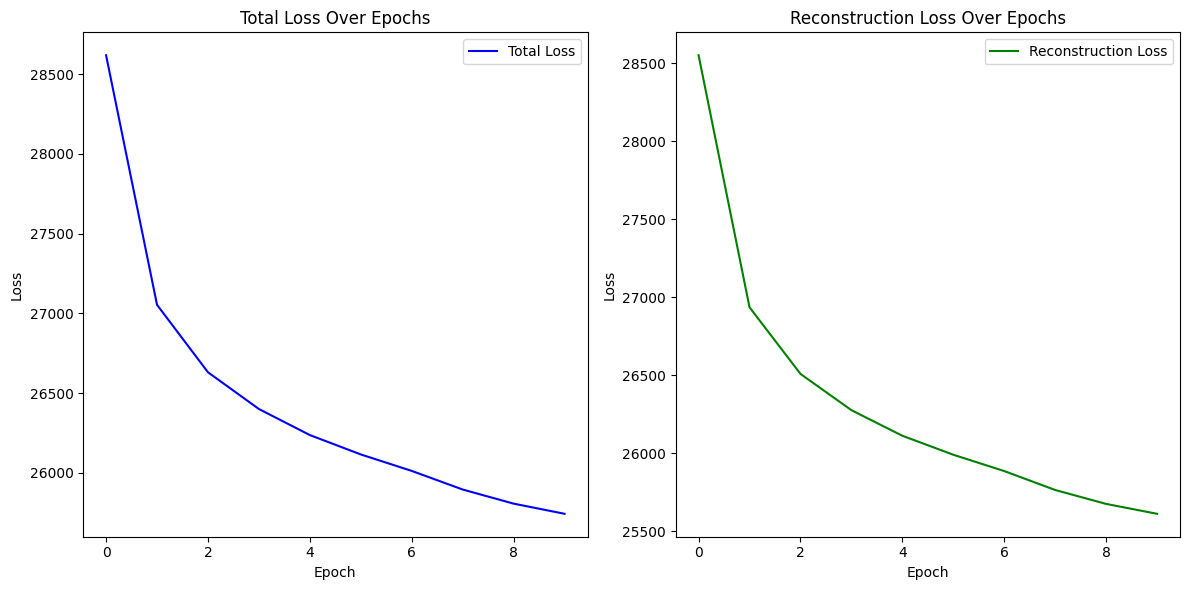

In [17]:
plot_training_loss(train_loss_history, recon_loss_history)

## Generate and Save for Part 4

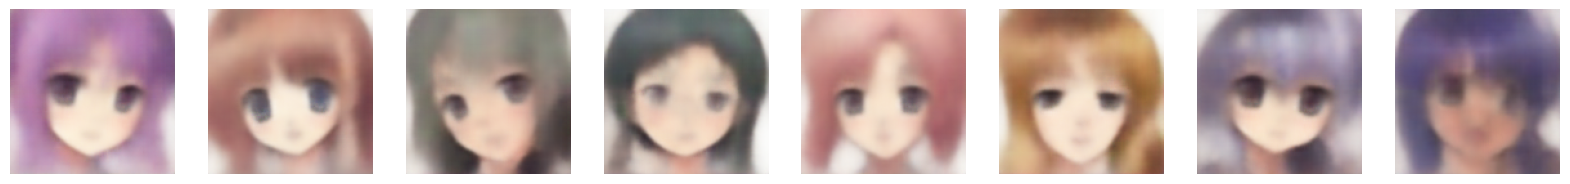

In [25]:
generate_and_save_images_vae(model, num_images=8)

## Train Convolutional VAE on Cartoon Face

In [26]:
# Reinitialize
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

cartoon_train_loss_history, cartoon_recon_loss_history, cartoon_kld_loss_history = train_vae(model, cartoon_dataloader, num_epochs=10)

Epoch 1/10: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s, loss=8.42e+5]


Epoch 1, Total Loss: 10863.93998125, Recon Loss: 10863.8790125, KLD Loss: 0.00018654936866369098


Epoch 2/10: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s, loss=7.62e+5]


Epoch 2, Total Loss: 10090.70713375, Recon Loss: 10090.6464925, KLD Loss: 0.00019867991795763373


Epoch 3/10: 100%|██████████| 391/391 [03:06<00:00,  2.09it/s, loss=8.24e+5]


Epoch 3, Total Loss: 10075.3810425, Recon Loss: 10075.31705875, KLD Loss: 0.0002163674362236634


Epoch 4/10: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s, loss=7.8e+5] 


Epoch 4, Total Loss: 10067.2200025, Recon Loss: 10067.1508675, KLD Loss: 0.00022438392625190318


Epoch 5/10: 100%|██████████| 391/391 [03:06<00:00,  2.09it/s, loss=7.97e+5]


Epoch 5, Total Loss: 10062.941965, Recon Loss: 10062.86764, KLD Loss: 0.0002457204682286829


Epoch 6/10: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s, loss=7.86e+5]


Epoch 6, Total Loss: 10056.7477675, Recon Loss: 10056.66812, KLD Loss: 0.00026432352024130523


Epoch 7/10: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s, loss=8.27e+5]


Epoch 7, Total Loss: 10055.20518625, Recon Loss: 10055.124145, KLD Loss: 0.0002627961221151054


Epoch 8/10: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s, loss=7.94e+5]


Epoch 8, Total Loss: 10051.3303425, Recon Loss: 10051.249975, KLD Loss: 0.00024910163483582437


Epoch 9/10: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s, loss=8.14e+5]


Epoch 9, Total Loss: 10043.22252125, Recon Loss: 10043.14557375, KLD Loss: 0.0002347039117012173


Epoch 10/10: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s, loss=8.07e+5]

Epoch 10, Total Loss: 10041.6228775, Recon Loss: 10041.55143875, KLD Loss: 0.00021790007303934544


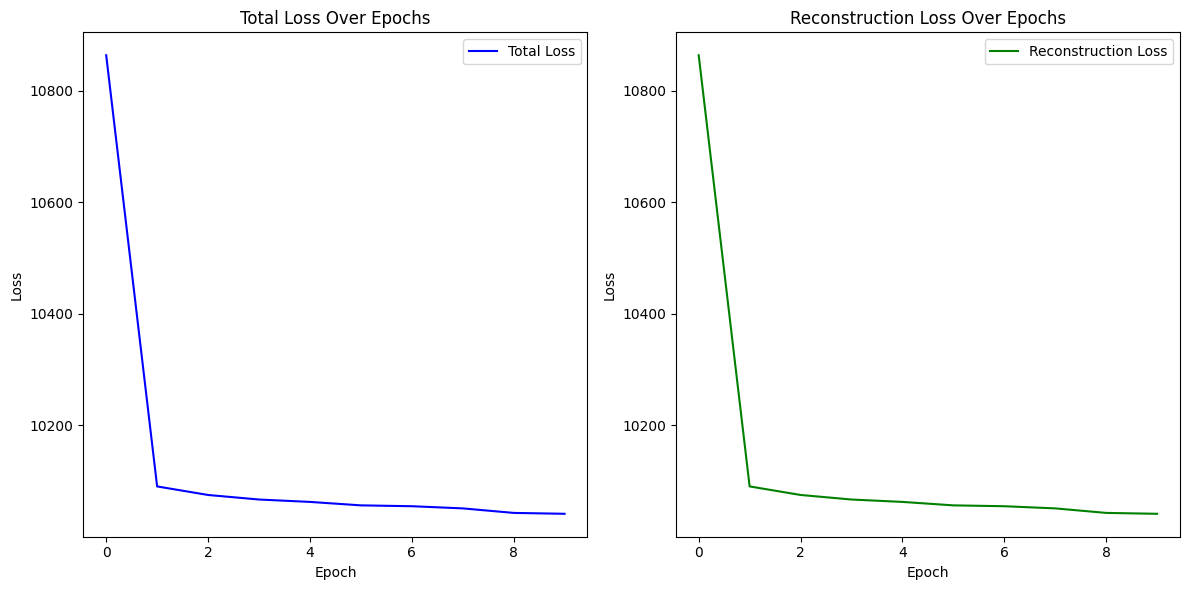

In [27]:
plot_training_loss(cartoon_train_loss_history, cartoon_recon_loss_history)

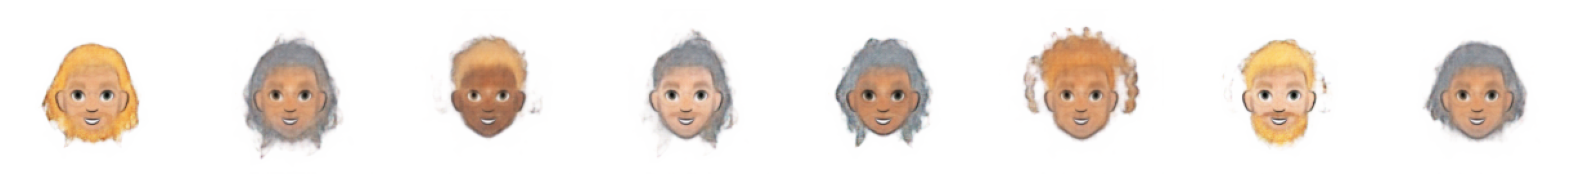

In [46]:
generate_and_plot_images(model, num_images=8)

# Part 3 - Conditional VAE

In [32]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        
        # Encoder
        self.enc_conv1 = nn.Conv2d(4, 64, kernel_size=4, stride=2, padding=1)  # 3 channels + 1 for label
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.enc_conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)  
        self.fc_mu = nn.Linear(1024, 128)
        self.fc_logvar = nn.Linear(1024, 128)
        
        # Decoder
        self.fc2 = nn.Linear(128 + 1, 1024)  # 1 label input for decoder
        self.fc3 = nn.Linear(1024, 512 * 8 * 8)  
        self.dec_conv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.dec_conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_conv4 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        
    def encode(self, x, c):
        c = c.view(c.size(0), 1, 1, 1).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        h = torch.relu(self.enc_conv1(x))
        h = torch.relu(self.enc_conv2(h))
        h = torch.relu(self.enc_conv3(h))
        h = torch.relu(self.enc_conv4(h))
        h = h.view(-1, 512 * 8 * 8)  
        h = torch.relu(self.fc1(h))
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        c = c.view(c.size(0), 1)  
        z = torch.cat([z, c], dim=1)
        h = torch.relu(self.fc2(z))
        h = torch.relu(self.fc3(h))
        h = h.view(-1, 512, 8, 8)  
        h = torch.relu(self.dec_conv1(h))
        h = torch.relu(self.dec_conv2(h))
        h = torch.relu(self.dec_conv3(h))
        return torch.sigmoid(self.dec_conv4(h))
    
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

## Train Loop

In [33]:
def train_cvae(model, dataloader, num_epochs=5):
    model.train()
    train_loss_history = []
    recon_loss_history = []
    kld_loss_history = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        recon_loss = 0
        kld_loss = 0
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device).float()
            labels = labels.view(labels.size(0), 1)
            optimizer.zero_grad()
            recon_images, mu, logvar = model(images, labels)
            bce_loss, kld_loss = loss_function(recon_images, images, mu, logvar)
            loss = bce_loss + kld_loss
            loss.backward()
            train_loss += loss.item()
            recon_loss += bce_loss.item()
            kld_loss += kld_loss.item()
            optimizer.step()
            
            progress_bar.set_postfix(loss=loss.item())
        
        avg_train_loss = train_loss / len(dataloader.dataset)
        avg_recon_loss = recon_loss / len(dataloader.dataset)
        avg_kld_loss = kld_loss / len(dataloader.dataset)
        train_loss_history.append(avg_train_loss)
        recon_loss_history.append(avg_recon_loss)
        kld_loss_history.append(avg_kld_loss)
        print(f"Epoch {epoch + 1}, Total Loss: {avg_train_loss}, Recon Loss: {avg_recon_loss}, KLD Loss: {avg_kld_loss}")
    
    return train_loss_history, recon_loss_history, kld_loss_history

## Generate Functions

In [34]:
def generate_and_plot_images_cvae(model, num_images=8, label):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, 128).to(device)
        labels = torch.full((num_images, 1), label, dtype=torch.float).to(device)
        generated_images = model.decode(z, labels)
        generated_images = generated_images.cpu()
        
        fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
        for i, ax in enumerate(axes):
            ax.imshow(generated_images[i].permute(1, 2, 0))
            ax.axis('off')
        plt.show()

## Train Conditional VAE

In [35]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD

model = CVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [36]:
cvae_train_loss_history, cvae_recon_loss_history, cvae_kld_loss_history = train_cvae(model, combined_dataloader, num_epochs=10)

Epoch 1/10: 100%|██████████| 782/782 [05:19<00:00,  2.44it/s, loss=5.48e+5]


Epoch 1, Total Loss: 197945311402.3426, Recon Loss: 20199.7511825, KLD Loss: 0.07131748646497726


Epoch 2/10: 100%|██████████| 782/782 [05:19<00:00,  2.45it/s, loss=4.79e+5]


Epoch 2, Total Loss: 16688.7640546875, Recon Loss: 16566.9773375, KLD Loss: 0.06589159369468689


Epoch 3/10: 100%|██████████| 782/782 [05:17<00:00,  2.46it/s, loss=5.17e+5]


Epoch 3, Total Loss: 16415.1795109375, Recon Loss: 16298.5224671875, KLD Loss: 0.07336969673633575


Epoch 4/10: 100%|██████████| 782/782 [05:15<00:00,  2.48it/s, loss=4.99e+5]


Epoch 4, Total Loss: 16287.7755775, Recon Loss: 16175.9100565625, KLD Loss: 0.07232663780450821


Epoch 5/10: 100%|██████████| 782/782 [05:16<00:00,  2.47it/s, loss=6.25e+5]


Epoch 5, Total Loss: 16213.646015625, Recon Loss: 16102.95662625, KLD Loss: 0.08467572182416916


Epoch 6/10: 100%|██████████| 782/782 [05:19<00:00,  2.44it/s, loss=5.38e+5]


Epoch 6, Total Loss: 16114.156661875, Recon Loss: 16005.90552625, KLD Loss: 0.06954392790794373


Epoch 7/10: 100%|██████████| 782/782 [05:18<00:00,  2.45it/s, loss=5.39e+5]


Epoch 7, Total Loss: 16625.54825, Recon Loss: 16513.513123125, KLD Loss: 0.07334394007921219


Epoch 8/10: 100%|██████████| 782/782 [05:18<00:00,  2.45it/s, loss=5.74e+5]


Epoch 8, Total Loss: 16189.8857675, Recon Loss: 16078.940044375, KLD Loss: 0.07943590730428696


Epoch 9/10: 100%|██████████| 782/782 [05:18<00:00,  2.46it/s, loss=5.95e+5]


Epoch 9, Total Loss: 16106.099780625, Recon Loss: 15997.34393125, KLD Loss: 0.08092067390680313


Epoch 10/10: 100%|██████████| 782/782 [05:18<00:00,  2.45it/s, loss=5.42e+5]

Epoch 10, Total Loss: 16066.61367625, Recon Loss: 15958.366270625, KLD Loss: 0.07024883478879929


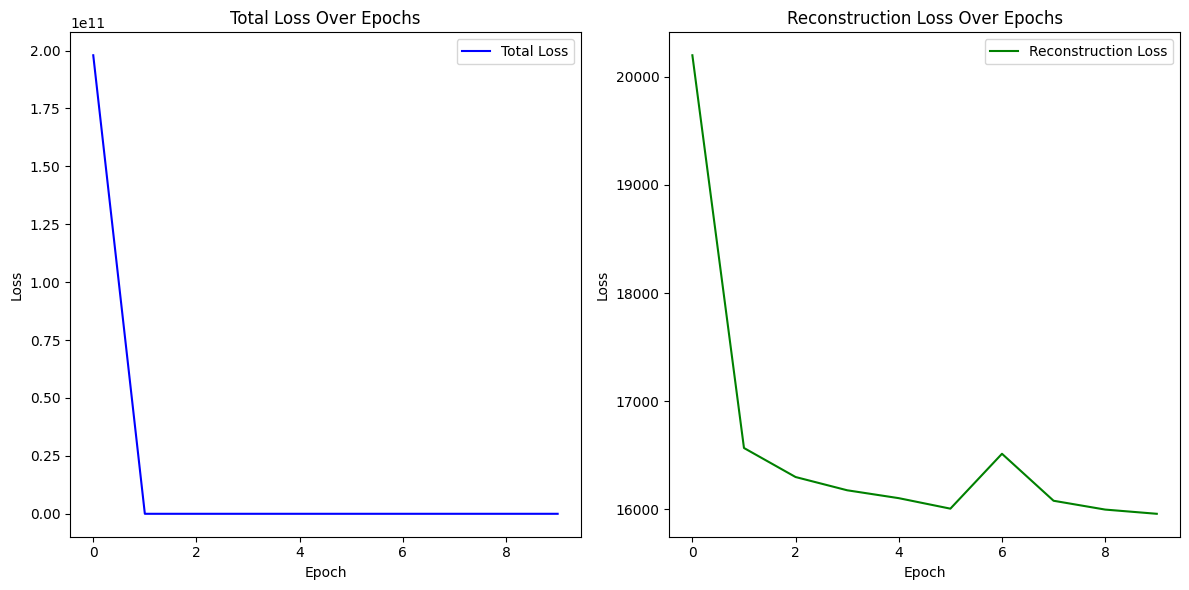

In [39]:
plot_training_loss(cvae_train_loss_history, cvae_recon_loss_history)

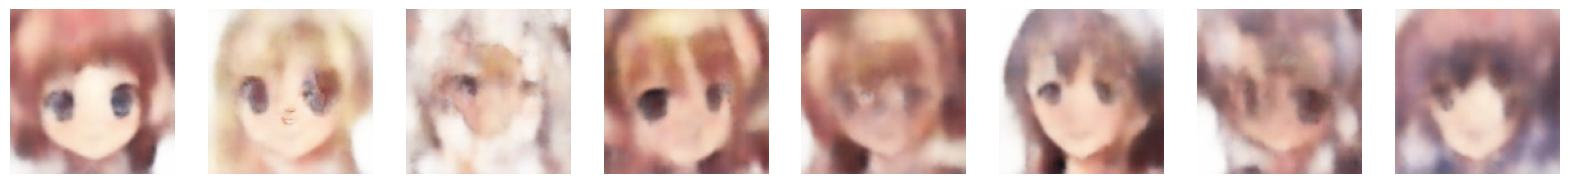

In [79]:
generate_and_plot_images_cvae(model, num_images=8, label=0)  # Anime

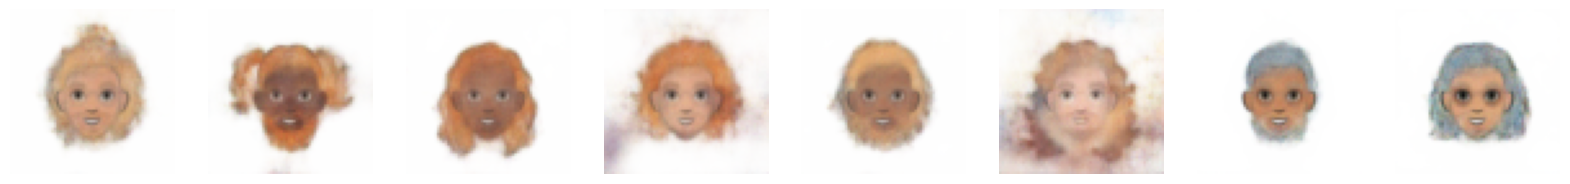

In [92]:
generate_and_plot_images_cvae(model, num_images=8, label=1)  # Cartoon

# Part 3 - 2nd Implementation - Conditional VAE

In [10]:
class HierarchicalCVAE(nn.Module):
    def __init__(self, input_dim=128*128, hidden_dim=512, latent_dim=20, n_labels=2, num_layers=2):
        super(HierarchicalCVAE, self).__init__()
        
        self.num_layers = num_layers
        self.latent_dim = latent_dim

        # Encoder
        self.fc1 = nn.Linear(input_dim + n_labels, hidden_dim)
        self.fc_mu = nn.ModuleList([nn.Linear(hidden_dim, latent_dim) for _ in range(num_layers)])
        self.fc_logvar = nn.ModuleList([nn.Linear(hidden_dim, latent_dim) for _ in range(num_layers)])
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim * num_layers + n_labels, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, c):
        h = F.relu(self.fc1(torch.cat([x, c], dim=1)))
        mu = [self.fc_mu[i](h) for i in range(self.num_layers)]
        logvar = [self.fc_logvar[i](h) for i in range(self.num_layers)]
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        h = F.relu(self.fc3(torch.cat([z, c], dim=1)))
        return torch.sigmoid(self.fc4(h))
    
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = torch.cat([self.reparameterize(mu[i], logvar[i]) for i in range(self.num_layers)], dim=1)
        return self.decode(z, c), mu, logvar

## Train Loop

In [11]:
def train_cvae(model, dataloader, num_epochs=5):
    model.train()
    train_loss_history = []
    recon_loss_history = []
    kld_loss_history = []

    for epoch in range(num_epochs):
        train_loss = 0
        recon_loss = 0
        kld_loss = 0
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        for batch_idx, (data, labels) in enumerate(progress_bar):
            data = data.view(-1, 128*128).to(device)
            labels = labels.to(device)
            one_hot_labels = F.one_hot(labels, num_classes=n_labels).float().to(device)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data, one_hot_labels)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            
            optimizer.step()
            
            bce_loss = F.binary_cross_entropy(recon_batch, data.view(-1, 128*128), reduction='sum').item()
            kld_loss = sum([-0.5 * torch.sum(1 + logvar[i] - mu[i].pow(2) - logvar[i].exp()).item() for i in range(len(mu))])

            recon_loss += bce_loss
            kld_loss += kld_loss

            progress_bar.set_postfix(loss=loss.item())
        
        avg_train_loss = train_loss / len(dataloader.dataset)
        avg_recon_loss = recon_loss / len(dataloader.dataset)
        avg_kld_loss = kld_loss / len(dataloader.dataset)
        train_loss_history.append(avg_train_loss)
        recon_loss_history.append(avg_recon_loss)
        kld_loss_history.append(avg_kld_loss)
        
        print(f"Epoch {epoch + 1}, Total Loss: {avg_train_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KLD Loss: {avg_kld_loss:.4f}")

    return train_loss_history, recon_loss_history, kld_loss_history

## Generate Functions

In [39]:
def generate_image(label, n_samples=1):
    model.eval()
    with torch.no_grad():
        sample = torch.randn(n_samples, latent_dim * num_layers).to(device)
        label_tensor = torch.tensor([label]*n_samples).to(device)
        one_hot_labels = F.one_hot(label_tensor, num_classes=n_labels).float().to(device)
        one_hot_labels = one_hot_labels.expand(n_samples, n_labels) 
        generated_images = model.decode(sample, one_hot_labels).cpu()
        generated_images = generated_images.view(-1, 1, 128, 128)
        return generated_images

def show_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for img, ax in zip(images, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

## Train  Hierarchical CVAE

In [18]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 128*128), reduction='sum')
    KLD = sum([-0.5 * torch.sum(1 + logvar[i] - mu[i].pow(2) - logvar[i].exp()) for i in range(len(mu))])
    return BCE + KLD
input_dim = 128 * 128
hidden_dim = 512
latent_dim = 20
num_layers = 2
n_labels = 2
num_epochs = 10

model = HierarchicalCVAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, n_labels=n_labels, num_layers=num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [21]:
train_loss_history, recon_loss_history, kld_loss_history = train_cvae(model, combined_dataloader, num_epochs=num_epochs)

Epoch 1/10: 100%|██████████| 782/782 [02:41<00:00,  4.85it/s, loss=2.09e+5]


Epoch 1, Total Loss: 5755.4130, Recon Loss: 5690.1915, KLD Loss: 0.0435


Epoch 2/10: 100%|██████████| 782/782 [02:40<00:00,  4.86it/s, loss=2.02e+5]


Epoch 2, Total Loss: 5726.6686, Recon Loss: 5662.1368, KLD Loss: 0.0429


Epoch 3/10: 100%|██████████| 782/782 [02:40<00:00,  4.87it/s, loss=1.92e+5]


Epoch 3, Total Loss: 5707.6944, Recon Loss: 5643.9539, KLD Loss: 0.0424


Epoch 4/10: 100%|██████████| 782/782 [02:40<00:00,  4.87it/s, loss=1.89e+5]


Epoch 4, Total Loss: 5694.9365, Recon Loss: 5631.7665, KLD Loss: 0.0399


Epoch 5/10: 100%|██████████| 782/782 [02:39<00:00,  4.90it/s, loss=1.98e+5]


Epoch 5, Total Loss: 5684.5543, Recon Loss: 5622.3189, KLD Loss: 0.0423


Epoch 6/10: 100%|██████████| 782/782 [02:40<00:00,  4.87it/s, loss=1.79e+5]


Epoch 6, Total Loss: 5676.0787, Recon Loss: 5614.1612, KLD Loss: 0.0383


Epoch 7/10: 100%|██████████| 782/782 [02:40<00:00,  4.87it/s, loss=1.73e+5]


Epoch 7, Total Loss: 5668.5566, Recon Loss: 5607.2120, KLD Loss: 0.0389


Epoch 8/10: 100%|██████████| 782/782 [02:42<00:00,  4.81it/s, loss=1.72e+5]


Epoch 8, Total Loss: 5663.6071, Recon Loss: 5602.7162, KLD Loss: 0.0361


Epoch 9/10: 100%|██████████| 782/782 [02:40<00:00,  4.86it/s, loss=1.93e+5]


Epoch 9, Total Loss: 5659.0916, Recon Loss: 5598.8973, KLD Loss: 0.0377


Epoch 10/10: 100%|██████████| 782/782 [02:40<00:00,  4.88it/s, loss=1.88e+5]

Epoch 10, Total Loss: 5654.3715, Recon Loss: 5594.4693, KLD Loss: 0.0393


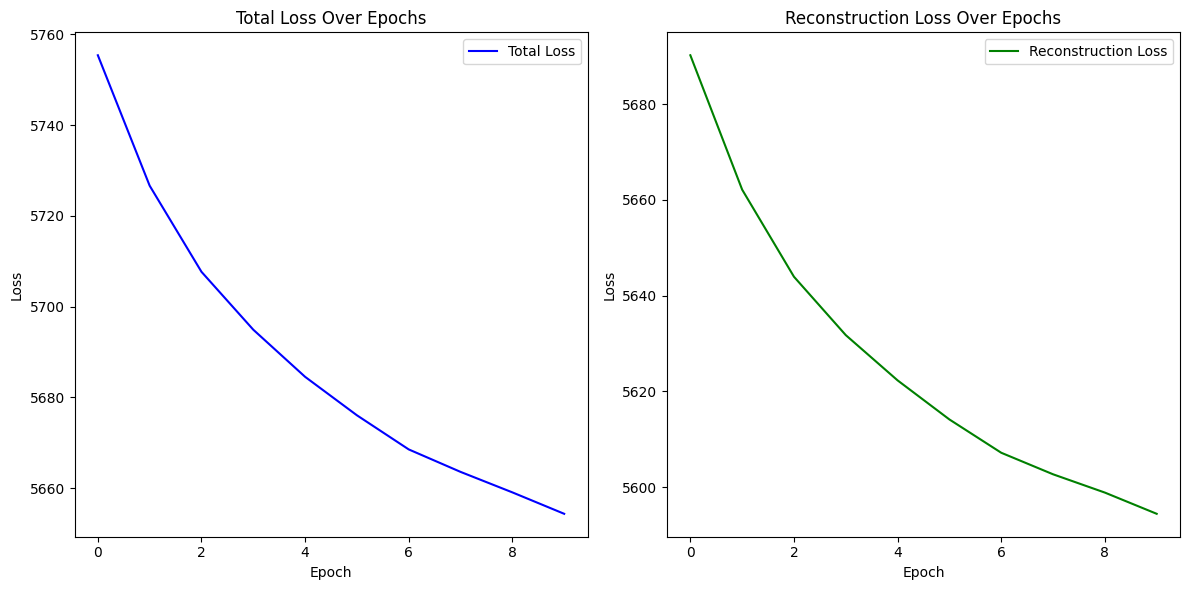

In [24]:
plot_training_loss(train_loss_history, recon_loss_history)

In [ ]:
anime_faces = generate_image(0, n_samples=8)
show_images(anime_faces)

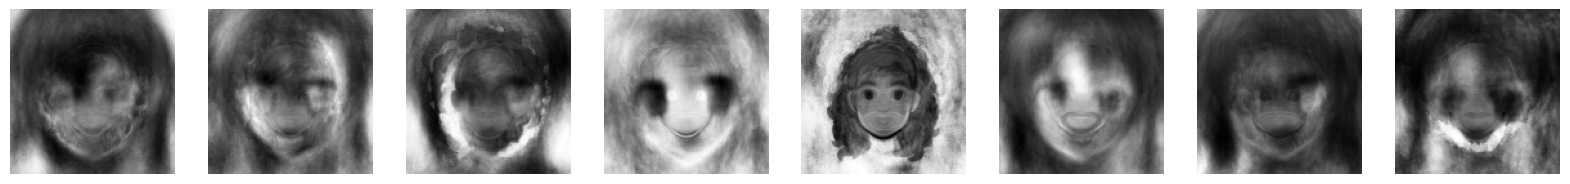

In [322]:
anime_faces = generate_image(0, n_samples=8)
show_images(anime_faces)

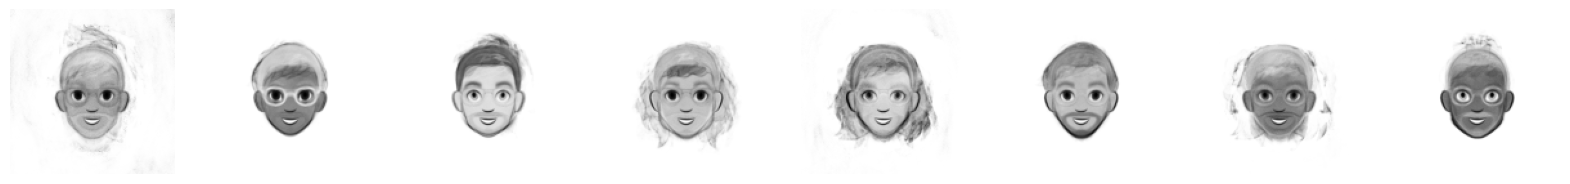

In [62]:
cartoon_faces = generate_image(1, n_samples=8)
show_images(cartoon_faces)

# Part 4 - VQ-VAE

## Vector Quantizer

In [205]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()  
        flat_x = x.view(-1, self.embedding_dim)
        distances = (flat_x ** 2).sum(dim=1, keepdim=True) + (self.embeddings.weight ** 2).sum(dim=1) - 2 * (flat_x @ self.embeddings.weight.t())
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.size(0), self.num_embeddings, device=x.device)
        encodings.scatter_(1, encoding_indices, 1)
        quantized = torch.matmul(encodings, self.embeddings.weight).view(x.size())
        e_latent_loss = torch.mean((quantized.detach() - x) ** 2)
        q_latent_loss = torch.mean((quantized - x.detach()) ** 2)
        loss = q_latent_loss + self.commitment_cost * e_latent_loss
        quantized = x + (quantized - x).detach()
        return quantized.permute(0, 3, 1, 2).contiguous(), loss, encoding_indices

## VQ-VAE Model

In [206]:
class VQVAE(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost):
        super(VQVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, num_hiddens // 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_hiddens // 2, num_hiddens, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_hiddens, num_hiddens, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.pre_vq_conv = nn.Conv2d(num_hiddens, embedding_dim, kernel_size=1, stride=1)
        
        self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, num_hiddens, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(num_hiddens, num_hiddens // 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(num_hiddens // 2, in_channels, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)
        quantized, vq_loss, _ = self.vq_layer(z)
        x_recon = self.decoder(quantized)
        return x_recon, vq_loss

## Train Loop

In [207]:
def train_vqvae(model, dataloader, num_epochs=10):
    model.train()
    train_loss_history = []
    recon_loss_history = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        recon_loss = 0
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        for images, _ in progress_bar:
            images = images.to(device)
            optimizer.zero_grad()
            recon_images, vq_loss = model(images)
            reconstruction_loss = nn.MSELoss()(recon_images, images)
            loss = reconstruction_loss + vq_loss
            loss.backward()
            train_loss += loss.item()
            recon_loss += reconstruction_loss.item()
            optimizer.step()
            
            progress_bar.set_postfix(loss=loss.item())
        
        avg_train_loss = train_loss / len(dataloader)
        avg_recon_loss = recon_loss / len(dataloader)
        train_loss_history.append(avg_train_loss)
        recon_loss_history.append(avg_recon_loss)
        print(f"Epoch {epoch + 1}, Total Loss: {avg_train_loss}, Recon Loss: {avg_recon_loss}")
    
    return train_loss_history, recon_loss_history

## Reconstruct Functions

In [214]:
def show_reconstructed_images(model, dataloader):
    model.eval()
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            recon_images, _ = model(images)
            recon_images = recon_images.cpu()
            images = images.cpu()
            fig, axes = plt.subplots(2, 8, figsize=(20, 5))
            for i in range(8):
                axes[0, i].imshow(images[i].permute(1, 2, 0))
                axes[0, i].set_title('Input Image')
                axes[0, i].axis('off')
                axes[1, i].imshow(recon_images[i].permute(1, 2, 0))
                axes[1, i].set_title('Output Image')
                axes[1, i].axis('off')
            plt.show()
            break

## Train VQ-VAE

In [209]:
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
embedding_dim = 64
num_embeddings = 512
commitment_cost = 0.25
learning_rate = 1e-3

model = VQVAE(3, num_hiddens, num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [210]:
train_loss_history, recon_loss_history = train_vqvae(model, anime_dataloader, num_epochs=10)

Epoch 1/10: 100%|██████████| 497/497 [02:23<00:00,  3.48it/s, loss=0.0146]


Epoch 1, Total Loss: 3.0019585985083217, Recon Loss: 0.03770406990381374


Epoch 2/10: 100%|██████████| 497/497 [02:23<00:00,  3.47it/s, loss=0.00938]


Epoch 2, Total Loss: 0.011350106815217247, Recon Loss: 0.0063372260799080555


Epoch 3/10: 100%|██████████| 497/497 [02:24<00:00,  3.45it/s, loss=0.00908]


Epoch 3, Total Loss: 0.009683923370446598, Recon Loss: 0.004090156636652452


Epoch 4/10: 100%|██████████| 497/497 [02:23<00:00,  3.47it/s, loss=0.00845]


Epoch 4, Total Loss: 0.009228192970636385, Recon Loss: 0.003336179629061933


Epoch 5/10: 100%|██████████| 497/497 [02:23<00:00,  3.47it/s, loss=0.00879]


Epoch 5, Total Loss: 0.008982848576541757, Recon Loss: 0.003007818307630133


Epoch 6/10: 100%|██████████| 497/497 [02:22<00:00,  3.48it/s, loss=0.00848]


Epoch 6, Total Loss: 0.008941219386905131, Recon Loss: 0.0027895217360385228


Epoch 7/10: 100%|██████████| 497/497 [02:22<00:00,  3.48it/s, loss=0.00945]


Epoch 7, Total Loss: 0.008583848628869479, Recon Loss: 0.00253135307647018


Epoch 8/10: 100%|██████████| 497/497 [02:24<00:00,  3.44it/s, loss=0.00782]


Epoch 8, Total Loss: 0.008516236549426973, Recon Loss: 0.0025077911418950713


Epoch 9/10: 100%|██████████| 497/497 [02:23<00:00,  3.47it/s, loss=0.00827]


Epoch 9, Total Loss: 0.008365668654366878, Recon Loss: 0.0024422177210097883


Epoch 10/10: 100%|██████████| 497/497 [02:23<00:00,  3.47it/s, loss=0.00754]

Epoch 10, Total Loss: 0.008194802149987856, Recon Loss: 0.0023879471911450985


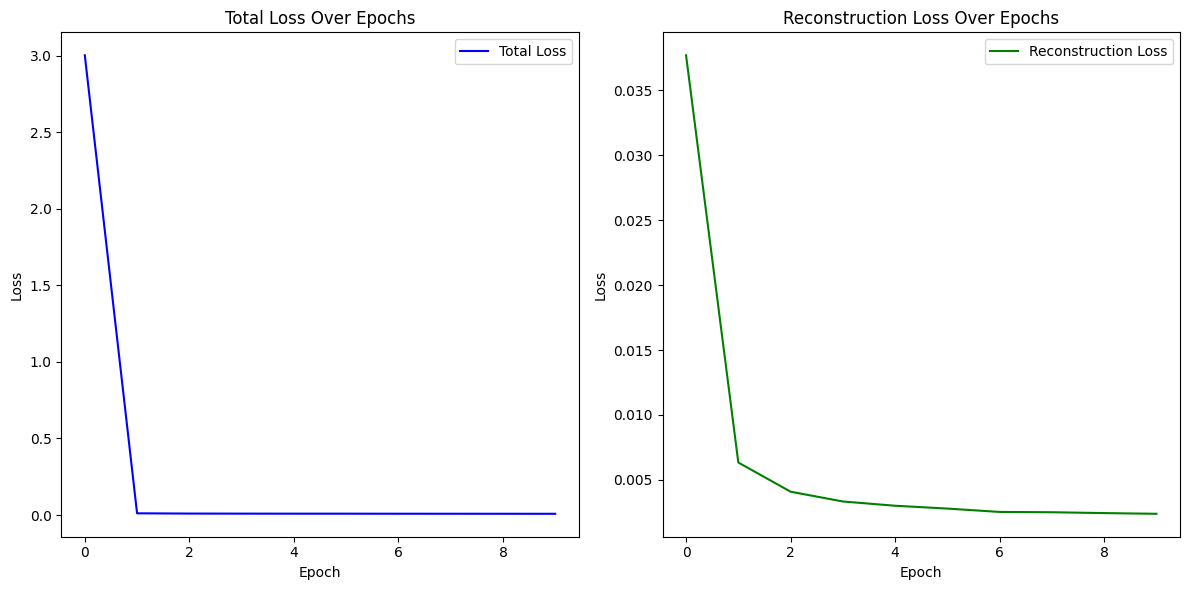

In [211]:
plot_training_loss(train_loss_history, recon_loss_history)

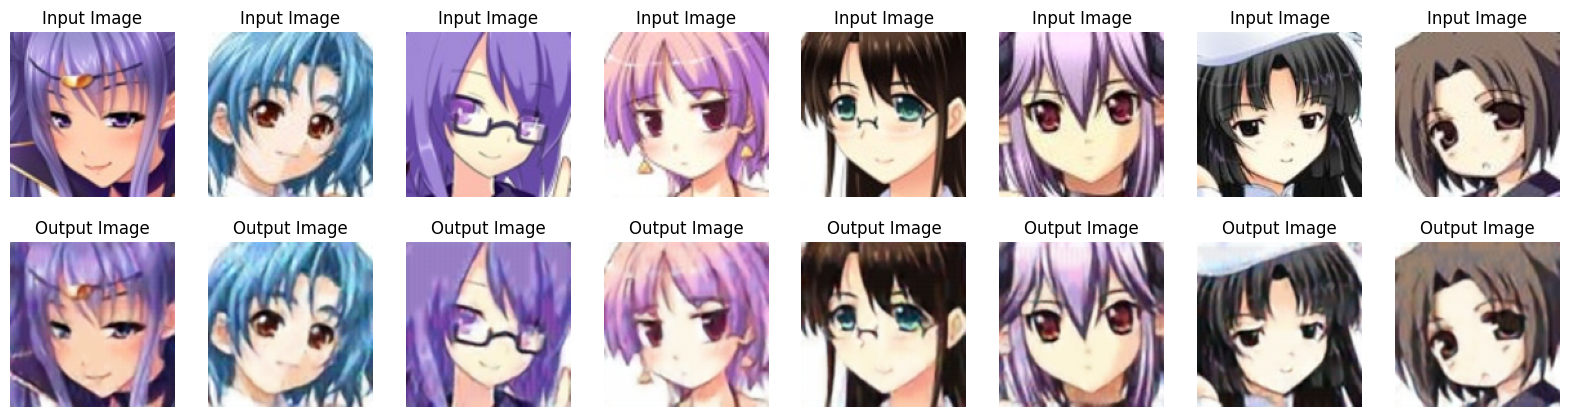

In [215]:
show_reconstructed_images(model, anime_dataloader)

## Load VAE Generated Images and Pass to VQ-VAE Model

In [223]:
def load_images(image_dir, transform, num_images=8):
    images = []
    for i in range(num_images):
        image_path = os.path.join(image_dir, f'vae_generated_image_{i}.png')
        image = Image.open(image_path).convert('RGB')
        image = transform(image)
        images.append(image)
    images = torch.stack(images)
    return images

def show_generated_and_reconstructed_images(model, image_dir, num_images=8):
    images = load_images(image_dir, transform, num_images)
    images = images.to(device)
    
    model.eval()
    with torch.no_grad():
        recon_images, _ = model(images)
        recon_images = recon_images.cpu()
        images = images.cpu()
        
        fig, axes = plt.subplots(2, num_images, figsize=(20, 5))
        for i in range(num_images):
            axes[0, i].set_title('VAE Image')
            axes[0, i].imshow(images[i].permute(1, 2, 0))
            axes[0, i].axis('off')
            axes[1, i].set_title('VQ-VAE Output')
            axes[1, i].imshow(recon_images[i].permute(1, 2, 0))
            axes[1, i].axis('off')
        plt.show()

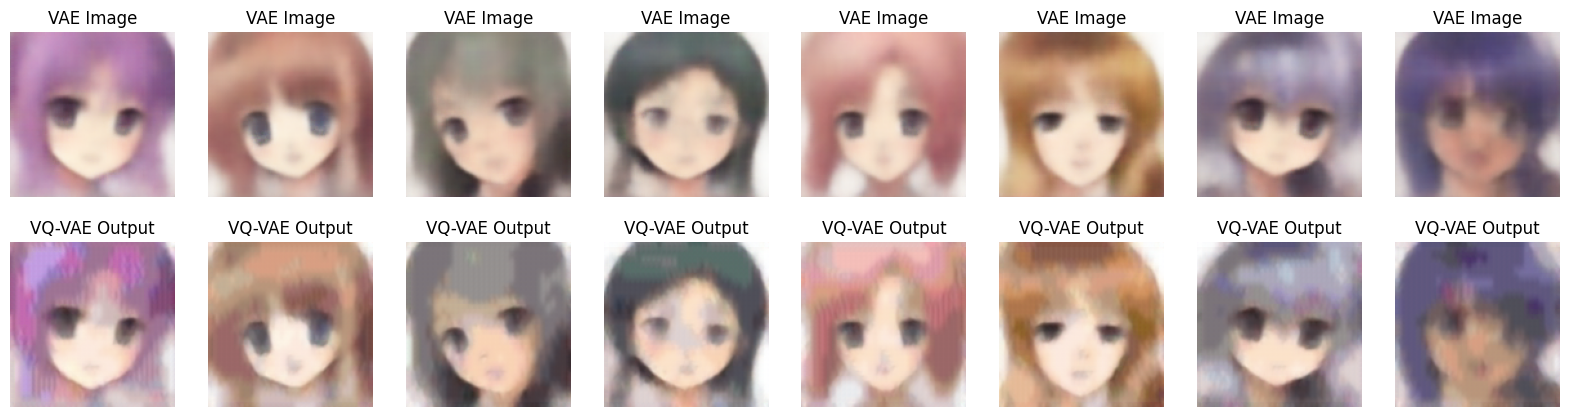

In [224]:
image_dir = '/kaggle/working/vae_generated_images'
show_generated_and_reconstructed_images(model, image_dir)